In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from classes import CustomLogisticRegression, LossTracker
from helpers import evaluate_model, load_data

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

seed = 777

### Load data

In [2]:
import pickle

(
    train_X_folds,
    train_y_folds,
    test_X_folds,
    test_y_folds,
    feature_names_folds,
    reverse_map_folds,
    k_fold_split
) = pickle.load(open('data/prepared_data.pkl', 'rb'))

In [3]:
train_X = train_X_folds[0]
train_y = train_y_folds[0]
test_X = test_X_folds[0]
test_y = test_y_folds[0]
feature_names = feature_names_folds[0]
reverse_map = reverse_map_folds[0]

### Evaluate

In [5]:
print("=== BASELINE MODEL EVALUATION ===")

# Create model with specific parameters
alpha = 10.0
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio}...")

tracker = LossTracker(train_X, train_y, test_X, test_y)

result = evaluate_model(
    lambda: CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=1000,
        tol=1e-6,
        class_weight="balanced",
        random_state=seed,
        callback=tracker.create_callback(alpha, l1_ratio)
    ),
    train_X,
    train_y,
    test_X,
    test_y,
    get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
)

print(f"✅ Model trained successfully!")
print(f"   Iterations: {result['model'].n_iter_}")
print(f"   Time: {result['training_time']:.2f}s")

=== BASELINE MODEL EVALUATION ===
Training model with α=10.0, L1 ratio=0.75...
✅ Model trained successfully!
   Iterations: 70
   Time: 9.14s


### Training Loss Curves


📈 LOSS CURVE ANALYSIS:


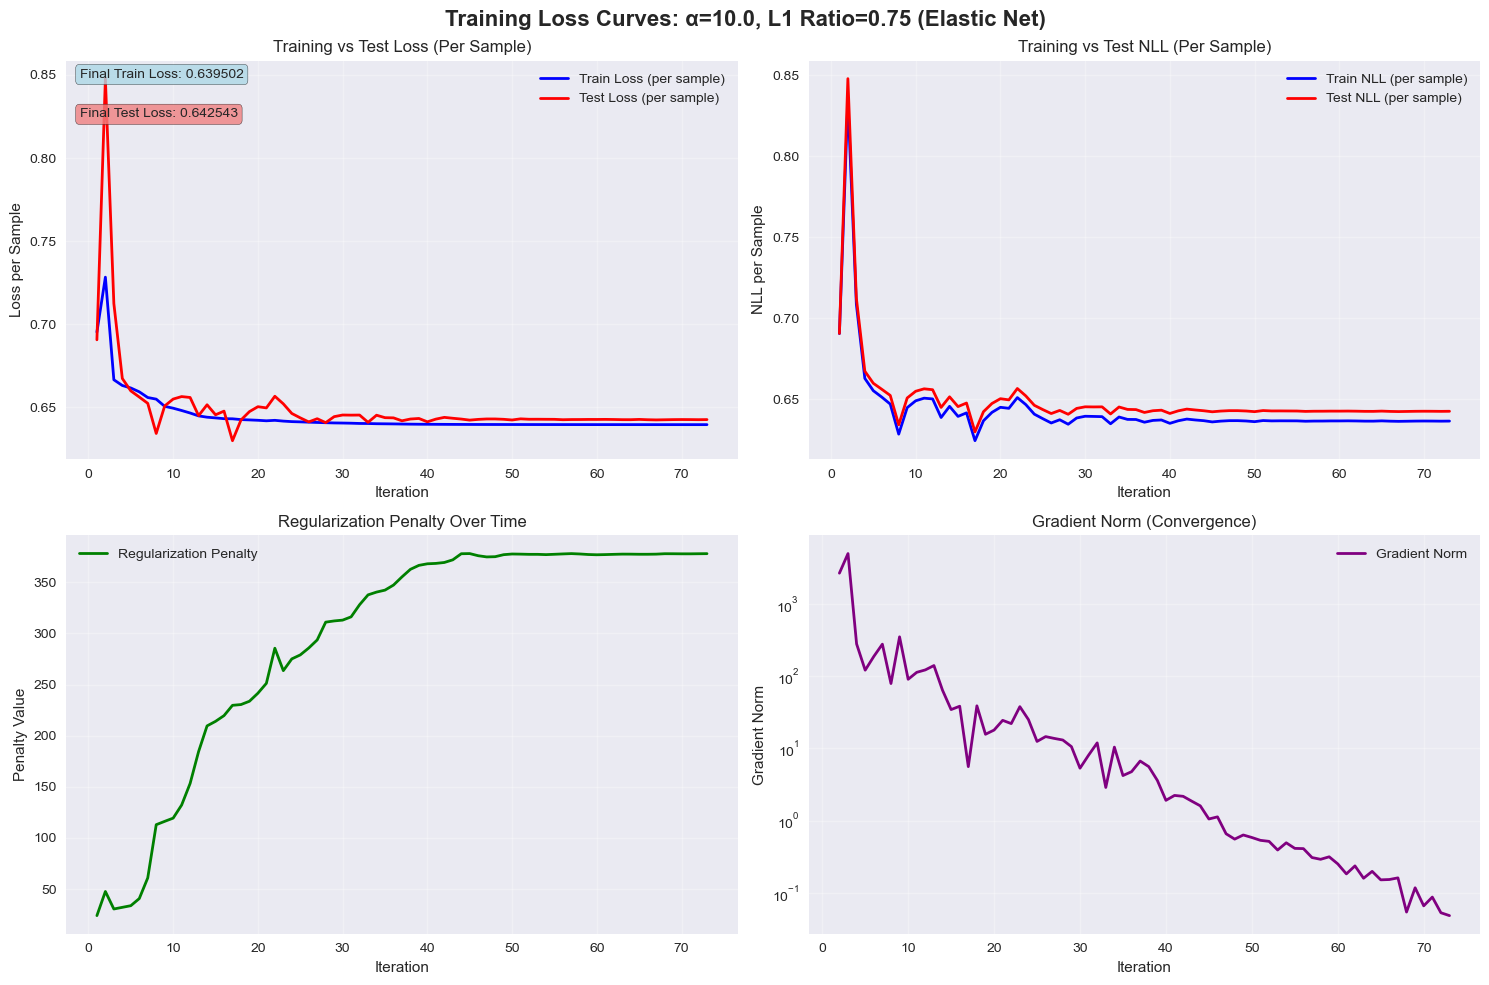

📊 LOSS ANALYSIS SUMMARY:
   Dataset sizes: Train=81,332, Test=20,434
   Initial Train Loss (per sample): 0.695221
   Final Train Loss (per sample): 0.639502
   Initial Test Loss (per sample): 0.690576
   Final Test Loss (per sample): 0.642543
   Train Loss Reduction: 0.055719
   Test Loss Reduction: 0.048033
   True Overfitting Gap (per sample): 0.003041
   Overfitting Ratio: 0.47%
   Final Regularization Penalty (per sample): 0.004648
   Regularization Ratio: 0.73%
   Final Gradient Norm: 0.048094
   Convergence Status: Not Converged

🔍 OVERFITTING ANALYSIS:
   Model shows overfitting: Test loss 0.48% higher than train loss
   Recent Train Improvement (last 5 iter): 0.253398
   Recent Test Improvement (last 5 iter): -0.263458
   ⚠️  Potential overfitting (train improving faster than test)


In [6]:
print("\n📈 LOSS CURVE ANALYSIS:")
print("=" * 50)

# Create loss curve plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Loss Curves: α=10.0, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. Training vs Test Loss (per sample)
ax1 = axes[0, 0]
if tracker.train_loss_history and tracker.test_loss_history:
    # Use the new convenience method
    per_sample_data = tracker.get_per_sample_losses()
    iterations = per_sample_data['iterations']
    train_loss_per_sample = per_sample_data['train_loss_per_sample']
    test_loss_per_sample = per_sample_data['test_loss_per_sample']
    
    ax1.plot(iterations, train_loss_per_sample, 'b-', label='Train Loss (per sample)', linewidth=2)
    ax1.plot(iterations, test_loss_per_sample, 'r-', label='Test Loss (per sample)', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss per Sample')
    ax1.set_title('Training vs Test Loss (Per Sample)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add final values as text
    ax1.text(0.02, 0.98, f'Final Train Loss: {train_loss_per_sample[-1]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax1.text(0.02, 0.88, f'Final Test Loss: {test_loss_per_sample[-1]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# 2. Training vs Test NLL (Negative Log-Likelihood) per sample
ax2 = axes[0, 1]
if tracker.train_nll_history and tracker.test_nll_history:
    train_nll_per_sample = per_sample_data['train_nll_per_sample']
    test_nll_per_sample = per_sample_data['test_nll_per_sample']
    
    ax2.plot(iterations, train_nll_per_sample, 'b-', label='Train NLL (per sample)', linewidth=2)
    ax2.plot(iterations, test_nll_per_sample, 'r-', label='Test NLL (per sample)', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('NLL per Sample')
    ax2.set_title('Training vs Test NLL (Per Sample)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Regularization Penalty
ax3 = axes[1, 0]
if tracker.penalty_history:
    ax3.plot(iterations, tracker.penalty_history, 'g-', label='Regularization Penalty', linewidth=2)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Penalty Value')
    ax3.set_title('Regularization Penalty Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Gradient Norm (Convergence)
ax4 = axes[1, 1]
if tracker.gradient_norm_history:
    ax4.plot(iterations[1:], tracker.gradient_norm_history[1:], 'purple', label='Gradient Norm', linewidth=2)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Gradient Norm')
    ax4.set_title('Gradient Norm (Convergence)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss analysis summary
if tracker.train_loss_history and tracker.test_loss_history:
    # Use the new convenience methods
    per_sample_data = tracker.get_per_sample_losses()
    overfitting_metrics = tracker.get_overfitting_metrics()
    
    n_train = len(train_y)
    n_test = len(test_y)
    
    print(f"📊 LOSS ANALYSIS SUMMARY:")
    print(f"   Dataset sizes: Train={n_train:,}, Test={n_test:,}")
    print(f"   Initial Train Loss (per sample): {per_sample_data['train_loss_per_sample'][0]:.6f}")
    print(f"   Final Train Loss (per sample): {overfitting_metrics['final_train_loss_per_sample']:.6f}")
    print(f"   Initial Test Loss (per sample): {per_sample_data['test_loss_per_sample'][0]:.6f}")
    print(f"   Final Test Loss (per sample): {overfitting_metrics['final_test_loss_per_sample']:.6f}")
    print(f"   Train Loss Reduction: {per_sample_data['train_loss_per_sample'][0] - overfitting_metrics['final_train_loss_per_sample']:.6f}")
    print(f"   Test Loss Reduction: {per_sample_data['test_loss_per_sample'][0] - overfitting_metrics['final_test_loss_per_sample']:.6f}")
    print(f"   True Overfitting Gap (per sample): {overfitting_metrics['overfitting_gap']:.6f}")
    print(f"   Overfitting Ratio: {overfitting_metrics['overfitting_ratio_percent']:.2f}%")
    
    if tracker.penalty_history:
        penalty_per_sample = per_sample_data['penalty_per_sample'][-1]
        print(f"   Final Regularization Penalty (per sample): {penalty_per_sample:.6f}")
        print(f"   Regularization Ratio: {penalty_per_sample / overfitting_metrics['final_train_loss_per_sample'] * 100:.2f}%")
    
    if tracker.gradient_norm_history:
        print(f"   Final Gradient Norm: {tracker.gradient_norm_history[-1]:.6f}")
        print(f"   Convergence Status: {'Converged' if tracker.gradient_norm_history[-1] < 1e-4 else 'Not Converged'}")
        
    # Additional overfitting analysis
    print(f"\n🔍 OVERFITTING ANALYSIS:")
    if overfitting_metrics['is_overfitting']:
        overfitting_severity = (overfitting_metrics['final_test_loss_per_sample'] - overfitting_metrics['final_train_loss_per_sample']) / overfitting_metrics['final_train_loss_per_sample'] * 100
        print(f"   Model shows overfitting: Test loss {overfitting_severity:.2f}% higher than train loss")
    else:
        print(f"   Model shows good generalization: Test loss lower than train loss")
        
    # Convergence analysis
    if len(tracker.train_loss_history) > 5:
        recent_train_improvement = tracker.train_loss_history[-5] - tracker.train_loss_history[-1]
        recent_test_improvement = tracker.test_loss_history[-5] - tracker.test_loss_history[-1]
        print(f"   Recent Train Improvement (last 5 iter): {recent_train_improvement:.6f}")
        print(f"   Recent Test Improvement (last 5 iter): {recent_test_improvement:.6f}")
        
        if recent_train_improvement < 1e-6 and recent_test_improvement < 1e-6:
            print(f"   ✅ Model has converged (minimal recent improvement)")
        elif recent_train_improvement > recent_test_improvement * 2:
            print(f"   ⚠️  Potential overfitting (train improving faster than test)")
else:
    print("⚠️  No loss history available from tracker")

### Model Performance

📊 MODEL PERFORMANCE METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.6639     0.6578    
Precision            0.1857     0.1810    
Recall               0.5988     0.5695    
F1-Score             0.2835     0.2747    

AUC                  0.6900     0.6715    
AUC-PR               0.2195     0.2141    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 48587      FP: 23713     
FN: 3624       TP: 5408      
Test Confusion Matrix:
TN: 12117      FP: 5992      
FN: 1001       TP: 1324      


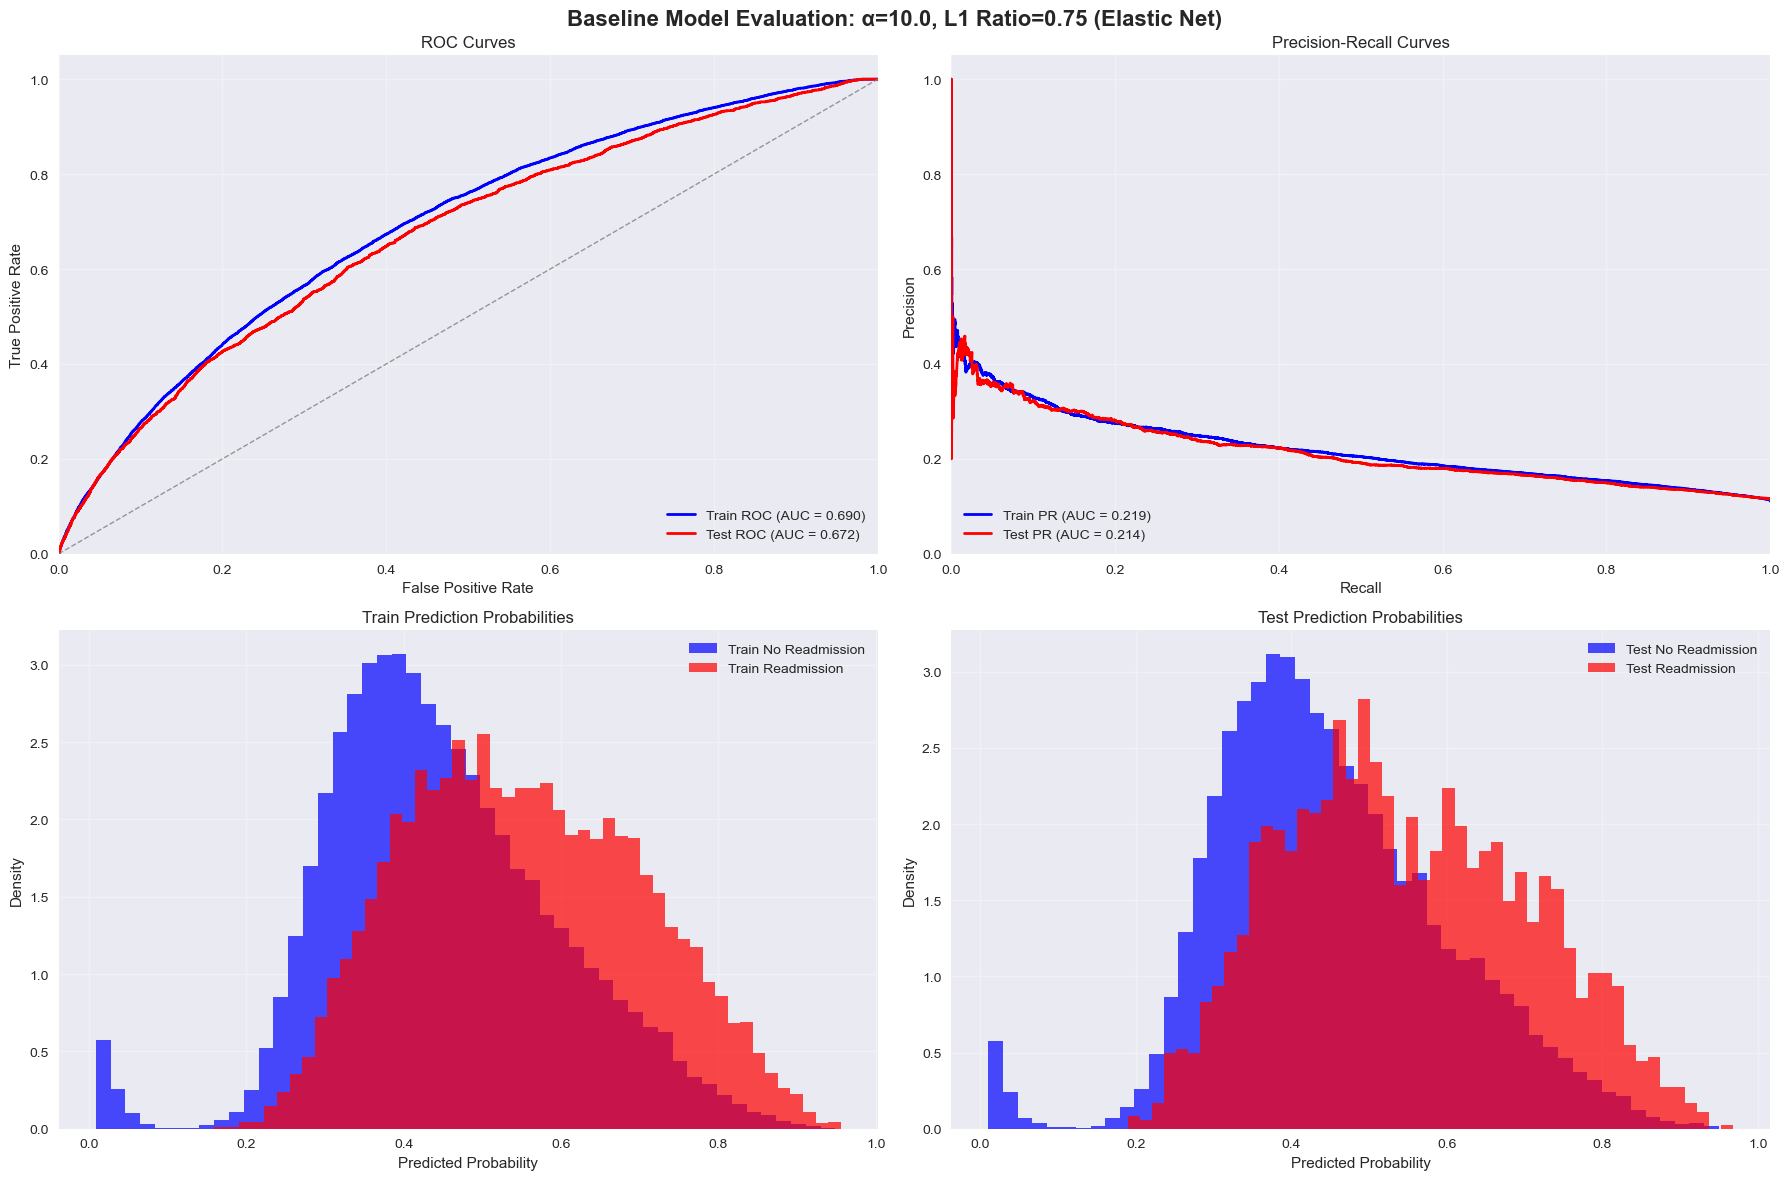


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.93      0.67      0.78     72300
   Readmission       0.19      0.60      0.28      9032

      accuracy                           0.66     81332
     macro avg       0.56      0.64      0.53     81332
  weighted avg       0.85      0.66      0.73     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.92      0.67      0.78     18109
   Readmission       0.18      0.57      0.27      2325

      accuracy                           0.66     20434
     macro avg       0.55      0.62      0.53     20434
  weighted avg       0.84      0.66      0.72     20434



In [7]:
# Get predictions and metrics
train_pred, test_pred = result['train_pred'], result['test_pred']
train_accuracy, test_accuracy, train_precision_score, test_precision_score, train_recall_score, test_recall_score, train_f1, test_f1 = result['train_accuracy'], result['test_accuracy'], result['train_precision_score'], result['test_precision_score'], result['train_recall_score'], result['test_recall_score'], result['train_f1'], result['test_f1']
train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc = result['train_roc_auc'], result['test_roc_auc'], result['train_pr_auc'], result['test_pr_auc']
train_cm, test_cm = result['train_cm'], result['test_cm']

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f}")
print(f"{'Precision':<20} {train_precision_score:<10.4f} {test_precision_score:<10.4f}")
print(f"{'Recall':<20} {train_recall_score:<10.4f} {test_recall_score:<10.4f}")
print(f"{'F1-Score':<20} {train_f1:<10.4f} {test_f1:<10.4f}")
print(f"\n{'AUC':<20} {train_roc_auc:<10.4f} {test_roc_auc:<10.4f}")
print(f"{'AUC-PR':<20} {train_pr_auc:<10.4f} {test_pr_auc:<10.4f}")

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm[0,0]:<10} FP: {train_cm[0,1]:<10}")
print(f"FN: {train_cm[1,0]:<10} TP: {train_cm[1,1]:<10}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm[0,0]:<10} FP: {test_cm[0,1]:<10}")
print(f"FN: {test_cm[1,0]:<10} TP: {test_cm[1,1]:<10}")

train_fpr, train_tpr = result['train_roc_curve']
test_fpr, test_tpr = result['test_roc_curve']
train_precision, train_recall = result['train_pr_curve']
test_precision, test_recall = result['test_pr_curve']
train_pred_proba, test_pred_proba = result['train_decision_score'], result['test_decision_score']

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation: α=10.0, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_roc_auc:.3f})')
ax1.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Test ROC (AUC = {test_roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall, train_precision, color='blue', lw=2, label=f'Train PR (AUC = {train_pr_auc:.3f})')
ax2.plot(test_recall, test_precision, color='red', lw=2, label=f'Test PR (AUC = {test_pr_auc:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred, target_names=['No Readmission', 'Readmission']))


### Interlude: If class balancing was not applied

=== WITHOUT CLASS BALANCING ===
Training model with α=10.0, L1 ratio=0.75 (Elastic Net)...
✅ Model trained successfully!
   Iterations: 70
   Time: 9.14s
📊 MODEL PERFORMANCE METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.8890     0.8857    
Precision            0.5057     0.3684    
Recall               0.0049     0.0060    
F1-Score             0.0097     0.0118    

AUC                  0.6840     0.6691    
AUC-PR               0.2184     0.2155    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 72257      FP: 43        
FN: 8988       TP: 44        
Test Confusion Matrix:
TN: 18085      FP: 24        
FN: 2311       TP: 14        


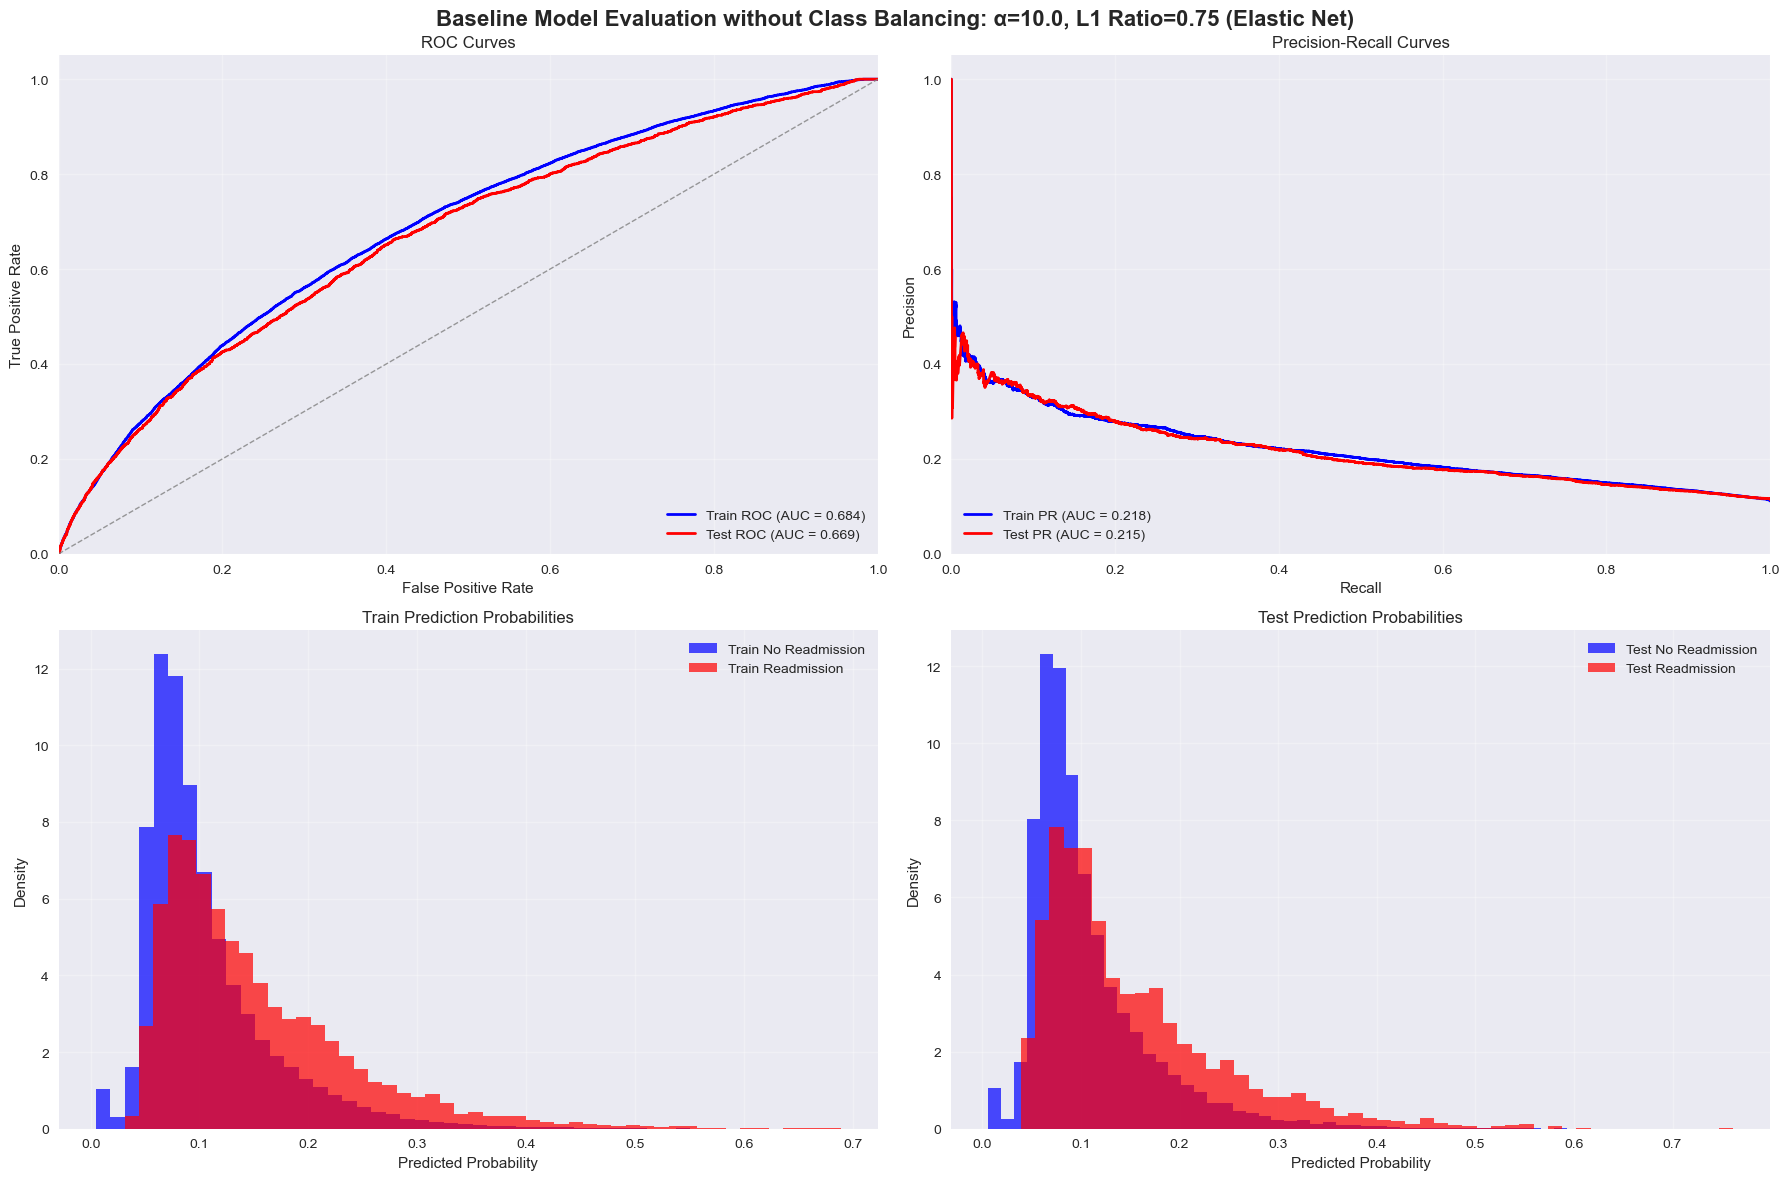


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     72300
   Readmission       0.51      0.00      0.01      9032

      accuracy                           0.89     81332
     macro avg       0.70      0.50      0.48     81332
  weighted avg       0.85      0.89      0.84     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     18109
   Readmission       0.37      0.01      0.01      2325

      accuracy                           0.89     20434
     macro avg       0.63      0.50      0.48     20434
  weighted avg       0.83      0.89      0.83     20434



In [8]:
print("=== WITHOUT CLASS BALANCING ===")

# Create model with specific parameters
alpha = 10.0
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio} (Elastic Net)...")

result_wo = evaluate_model(
    lambda: CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=200,
        tol=1e-6,
        random_state=seed,
        callback=tracker.create_callback(alpha, l1_ratio)
    ),
    train_X,
    train_y,
    test_X,
    test_y,
    get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
)

print(f"✅ Model trained successfully!")
print(f"   Iterations: {result['model'].n_iter_}")
print(f"   Time: {result['training_time']:.2f}s")

# Get predictions and metrics
train_pred_wo, test_pred_wo = result_wo['train_pred'], result_wo['test_pred']
train_accuracy_wo, test_accuracy_wo, train_precision_score_wo, test_precision_score_wo, train_recall_score_wo, test_recall_score_wo, train_f1_wo, test_f1_wo = result_wo['train_accuracy'], result_wo['test_accuracy'], result_wo['train_precision_score'], result_wo['test_precision_score'], result_wo['train_recall_score'], result_wo['test_recall_score'], result_wo['train_f1'], result_wo['test_f1']
train_roc_auc_wo, test_roc_auc_wo, train_pr_auc_wo, test_pr_auc_wo = result_wo['train_roc_auc'], result_wo['test_roc_auc'], result_wo['train_pr_auc'], result_wo['test_pr_auc']
train_cm_wo, test_cm_wo = result_wo['train_cm'], result_wo['test_cm']

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy_wo:<10.4f} {test_accuracy_wo:<10.4f}")
print(f"{'Precision':<20} {train_precision_score_wo:<10.4f} {test_precision_score_wo:<10.4f}")
print(f"{'Recall':<20} {train_recall_score_wo:<10.4f} {test_recall_score_wo:<10.4f}")
print(f"{'F1-Score':<20} {train_f1_wo:<10.4f} {test_f1_wo:<10.4f}")
print(f"\n{'AUC':<20} {train_roc_auc_wo:<10.4f} {test_roc_auc_wo:<10.4f}")
print(f"{'AUC-PR':<20} {train_pr_auc_wo:<10.4f} {test_pr_auc_wo:<10.4f}")

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm_wo[0,0]:<10} FP: {train_cm_wo[0,1]:<10}")
print(f"FN: {train_cm_wo[1,0]:<10} TP: {train_cm_wo[1,1]:<10}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm_wo[0,0]:<10} FP: {test_cm_wo[0,1]:<10}")
print(f"FN: {test_cm_wo[1,0]:<10} TP: {test_cm_wo[1,1]:<10}")

train_fpr_wo, train_tpr_wo = result_wo['train_roc_curve']
test_fpr_wo, test_tpr_wo = result_wo['test_roc_curve']
train_precision_wo, train_recall_wo = result_wo['train_pr_curve']
test_precision_wo, test_recall_wo = result_wo['test_pr_curve']
train_pred_proba_wo, test_pred_proba_wo = result_wo['train_decision_score'], result_wo['test_decision_score']

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation without Class Balancing: α=10.0, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr_wo, train_tpr_wo, color='blue', lw=2, label=f'Train ROC (AUC = {train_roc_auc_wo:.3f})')
ax1.plot(test_fpr_wo, test_tpr_wo, color='red', lw=2, label=f'Test ROC (AUC = {test_roc_auc_wo:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall_wo, train_precision_wo, color='blue', lw=2, label=f'Train PR (AUC = {train_pr_auc_wo:.3f})')
ax2.plot(test_recall_wo, test_precision_wo, color='red', lw=2, label=f'Test PR (AUC = {test_pr_auc_wo:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba_wo[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba_wo[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba_wo[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba_wo[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred_wo, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred_wo, target_names=['No Readmission', 'Readmission']))


### Feature Importance Analysis

In [9]:
print("=== FEATURE ANALYSIS: ALPHA=10.0, L1 RATIO=0.75 (ELASTIC NET) ===")

print(f"Total features: {len(feature_names)}")

# Analyze coefficient magnitudes
coef = result['model'].coef_
coef_magnitudes = np.abs(coef)
non_zero_coefs = coef_magnitudes > 1e-6
n_nonzero = np.sum(non_zero_coefs)
n_zero = len(coef) - n_nonzero

print(f"Non-zero coefficients: {n_nonzero} ({n_nonzero/len(coef)*100:.1f}%)")
print(f"Zero coefficients: {n_zero} ({n_zero/len(coef)*100:.1f}%)")

# Get p-values from the model
print("\n🔍 Calculating p-values for coefficients...")
intercept_p, coef_p = result['model'].get_p_values(train_X, train_y)

# Create feature importance dataframe
feature_analysis_df = pd.DataFrame({
    'feature_name': feature_names,
    'coefficient': coef,
    'abs_coefficient': coef_magnitudes,
    'p_value': coef_p
})

# Separate positive and negative features
positive_features = feature_analysis_df[feature_analysis_df['coefficient'] > 0].sort_values('coefficient', ascending=False)
negative_features = feature_analysis_df[feature_analysis_df['coefficient'] < 0].sort_values('coefficient', ascending=True)

# Format p-values with significance stars
def format_p_value(p_val):
    if p_val < 0.001:
        return f"{p_val:.6f}***"
    elif p_val < 0.01:
        return f"{p_val:.6f}**"
    elif p_val < 0.05:
        return f"{p_val:.6f}*"
    else:
        return f"{p_val:.6f}"

print(f"\n🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):")
# Slice the dataframe to show only relevant columns (excluding abs_coefficient)
display_cols = ['coefficient', 'p_value']
positive_display = positive_features[display_cols].head(15)
positive_display.index = positive_features['feature_name'].head(15)

# Format columns for better display
positive_display['coefficient'] = positive_display['coefficient'].map('{:.4f}'.format)
positive_display['p_value'] = positive_display['p_value'].map(format_p_value)

# Apply left alignment to feature names and p-values
positive_display.style.set_properties(subset=['p_value'], **{'text-align': 'left'})

=== FEATURE ANALYSIS: ALPHA=10.0, L1 RATIO=0.75 (ELASTIC NET) ===
Total features: 416
Non-zero coefficients: 416 (100.0%)
Zero coefficients: 0 (0.0%)

🔍 Calculating p-values for coefficients...

🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):


,coefficient,p_value
feature_name,,
discharge_disposition_id_28,1.4093,0.000000***
discharge_disposition_id_22,1.3223,0.000000***
discharge_disposition_id_5,0.9986,0.000000***
discharge_disposition_id_15,0.7510,0.000884***
discharge_disposition_id_2,0.5445,0.000000***
medical_specialty_Hematology/Oncology,0.5253,0.000358***
diag_PC19,0.4816,0.000000***
diag_PC143,0.3981,0.001751**
medical_specialty_Hematology,0.3796,0.083562


In [10]:
print(f"\n🔴 TOP 15 NEGATIVE FEATURES (DECREASE READMISSION RISK):")
# Slice the dataframe to show only relevant columns (excluding abs_coefficient)
negative_display = negative_features[display_cols].head(15)
negative_display.index = negative_features['feature_name'].head(15)

# Format columns for better display
negative_display['coefficient'] = negative_display['coefficient'].map('{:.4f}'.format)
negative_display['p_value'] = negative_display['p_value'].map(format_p_value)

# Apply left alignment to feature names and p-values
negative_display.style.set_properties(subset=['p_value'], **{'text-align': 'left'})


🔴 TOP 15 NEGATIVE FEATURES (DECREASE READMISSION RISK):


,coefficient,p_value
feature_name,,
discharge_disposition_id_11,-3.5444,0.000000***
discharge_disposition_id_13,-0.7343,0.000000***
discharge_disposition_id_14,-0.5674,0.000042***
discharge_disposition_id_23,-0.5394,0.000061***
diag_PC129,-0.4807,0.000224***
medical_specialty_Surgery-Cardiovascular/Thoracic,-0.4687,0.000011***
medical_specialty_ObstetricsandGynecology,-0.4169,0.004962**
gender_Male x age_[20-30),-0.3810,0.473753
diag_PC43,-0.3724,0.000000***


In [11]:
# Summary statistics
print(f"\n📈 COEFFICIENT SUMMARY STATISTICS:")
print(f"Max coefficient: {feature_analysis_df['coefficient'].max():.4f}")
print(f"Mean positive coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] > 0]['coefficient'].mean():.4f}")
print(f"Median coefficient: {feature_analysis_df['coefficient'].median():.4f}")
print(f"Mean negative coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] < 0]['coefficient'].mean():.4f}")
print(f"Min coefficient: {feature_analysis_df['coefficient'].min():.4f}")
print(f"Std coefficient: {feature_analysis_df['coefficient'].std():.4f}")

print(f"\n📊 P-VALUE SUMMARY STATISTICS:")
print(f"Min p-value: {feature_analysis_df['p_value'].min():.6f}")
print(f"Max p-value: {feature_analysis_df['p_value'].max():.6f}")
print(f"Mean p-value: {feature_analysis_df['p_value'].mean():.6f}")
print(f"Median p-value: {feature_analysis_df['p_value'].median():.6f}")
print(f"Features with p < 0.05: {np.sum(feature_analysis_df['p_value'] < 0.05)} ({np.sum(feature_analysis_df['p_value'] < 0.05)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with p < 0.01: {np.sum(feature_analysis_df['p_value'] < 0.01)} ({np.sum(feature_analysis_df['p_value'] < 0.01)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with p < 0.001: {np.sum(feature_analysis_df['p_value'] < 0.001)} ({np.sum(feature_analysis_df['p_value'] < 0.001)/len(feature_analysis_df)*100:.1f}%)")

# Coefficient magnitude analysis
print(f"\n🎯 COEFFICIENT MAGNITUDE ANALYSIS:")
print(f"Features with |coefficient| > 1.0: {np.sum(feature_analysis_df['abs_coefficient'] > 1.0)} ({np.sum(feature_analysis_df['abs_coefficient'] > 1.0)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.5: {np.sum(feature_analysis_df['abs_coefficient'] > 0.5)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.5)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.1: {np.sum(feature_analysis_df['abs_coefficient'] > 0.1)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.1)/len(feature_analysis_df)*100:.1f}%)")


📈 COEFFICIENT SUMMARY STATISTICS:
Max coefficient: 1.4093
Mean positive coefficient: 0.0974
Median coefficient: 0.0000
Mean negative coefficient: -0.1018
Min coefficient: -3.5444
Std coefficient: 0.2508

📊 P-VALUE SUMMARY STATISTICS:
Min p-value: 0.000000
Max p-value: 0.999999
Mean p-value: 0.623573
Median p-value: 0.849757
Features with p < 0.05: 73 (17.5%)
Features with p < 0.01: 55 (13.2%)
Features with p < 0.001: 42 (10.1%)

🎯 COEFFICIENT MAGNITUDE ANALYSIS:
Features with |coefficient| > 1.0: 3 (0.7%)
Features with |coefficient| > 0.5: 10 (2.4%)
Features with |coefficient| > 0.1: 124 (29.8%)


=== FEATURE ANALYSIS VISUALIZATIONS ===


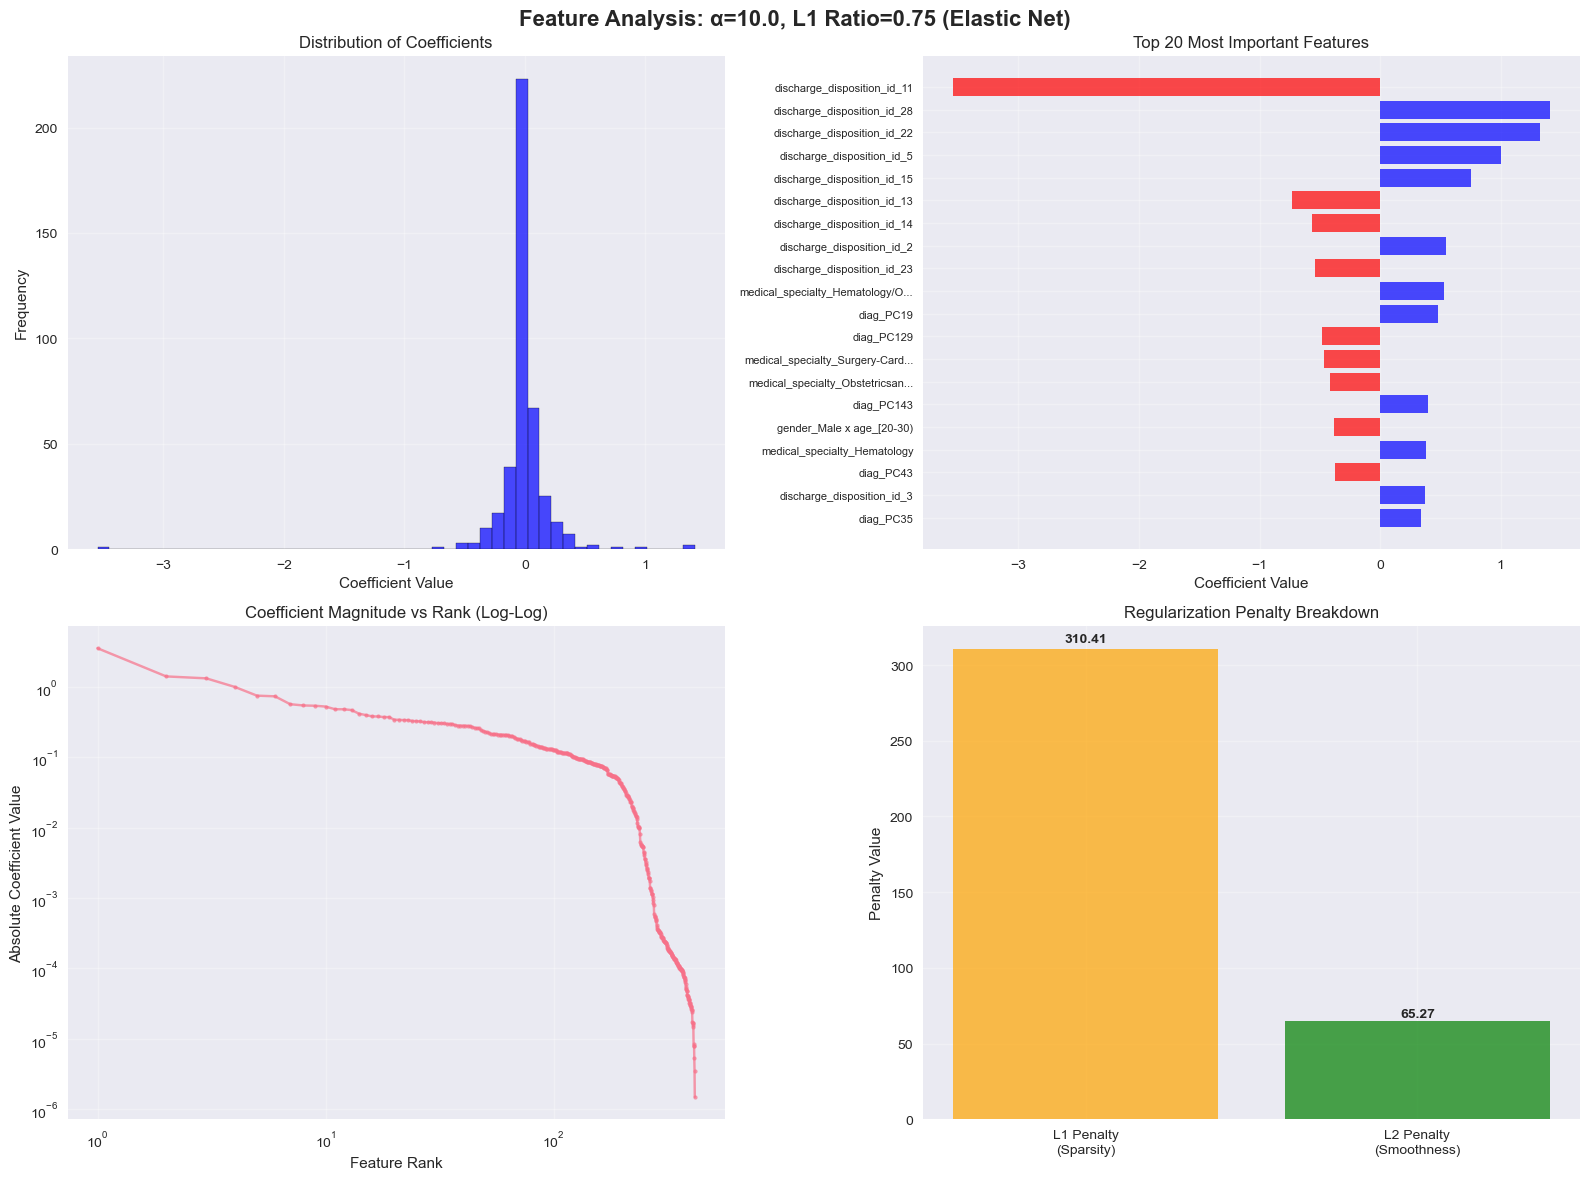

In [12]:
# FEATURE ANALYSIS VISUALIZATIONS
print("=== FEATURE ANALYSIS VISUALIZATIONS ===")

# Create feature analysis plots (removed absolute coefficient plot and pie plot)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Analysis: α=10.0, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. Coefficient Distribution
ax1 = axes[0, 0]
ax1.hist(feature_analysis_df['coefficient'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Coefficients')
ax1.grid(True, alpha=0.3)

# 2. Top 20 Features Bar Plot (flipped y-axis labels)
ax2 = axes[0, 1]
top_20 = feature_analysis_df.sort_values('abs_coefficient', ascending=False).head(20)
y_pos = np.arange(len(top_20))
colors = ['red' if x < 0 else 'blue' for x in top_20['coefficient']]
ax2.barh(y_pos, top_20['coefficient'], color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
# Flip y-axis labels to read top to bottom
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_20['feature_name']], fontsize=8)
ax2.invert_yaxis()  # This flips the y-axis so labels read top to bottom
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top 20 Most Important Features')
ax2.grid(True, alpha=0.3)

# 3. Coefficient Magnitude vs Rank
ax3 = axes[1, 0]
sorted_features = feature_analysis_df.sort_values('abs_coefficient', ascending=False)
ranks = np.arange(1, len(sorted_features) + 1)
ax3.loglog(ranks, sorted_features['abs_coefficient'], 'o-', markersize=3, alpha=0.7)
ax3.set_xlabel('Feature Rank')
ax3.set_ylabel('Absolute Coefficient Value')
ax3.set_title('Coefficient Magnitude vs Rank (Log-Log)')
ax3.grid(True, alpha=0.3)

# 4. Regularization Penalty Breakdown
ax4 = axes[1, 1]
l1_penalty = alpha * l1_ratio * np.sum(np.abs(coef))
l2_penalty = alpha * (1 - l1_ratio) * np.sum(coef ** 2)
total_penalty = l1_penalty + l2_penalty

penalty_data = [l1_penalty, l2_penalty]
penalty_labels = ['L1 Penalty\n(Sparsity)', 'L2 Penalty\n(Smoothness)']
colors = ['orange', 'green']

bars = ax4.bar(penalty_labels, penalty_data, color=colors, alpha=0.7)
ax4.set_ylabel('Penalty Value')
ax4.set_title('Regularization Penalty Breakdown')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, penalty_data):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Supplementary: Feature analysis using pseudo R²

In [13]:
print(f"📊 FEATURE ANALYSIS: PSEUDO R-SQUARED")
print("=" * 70)

# Calculate pseudo R-squared and binary metrics for each feature individually
feature_pseudo_r2_scores = []
feature_auc_scores = []
feature_log_loss_scores = []

print("🔍 Calculating individual feature pseudo R-squared...")

# Calculate sample weights for balanced class weight
classes = np.unique(train_y)
class_weights = compute_class_weight('balanced', classes=classes, y=train_y)
weight_dict = dict(zip(classes, class_weights))
sample_weights = np.array([weight_dict[label] for label in train_y])

# Null model: With class balancing, the null model is just 50/50
log_likelihood_null = -np.log(0.5)

for i, feature_name in enumerate(feature_names):
    # Extract single feature
    X_single = train_X[:, i:i+1]  # Keep 2D shape
    
    # Fit logistic regression for this single feature
    lr = LogisticRegression(random_state=seed, max_iter=1000, class_weight='balanced')
    lr.fit(X_single, train_y)
    
    # Predict probabilities on training set
    y_pred_proba = lr.predict_proba(X_single)[:, 1]
    y_pred = lr.predict(X_single)

    # Calculate log loss
    log_loss_score = log_loss(train_y, y_pred_proba, sample_weight=sample_weights)
    feature_log_loss_scores.append(log_loss_score)
    
    # Calculate pseudo R-squared (McFadden's)
    # Pseudo R² = 1 - (log-likelihood of model / log-likelihood of null model)    
    pseudo_r2 = 1 - (log_loss_score / log_likelihood_null) if log_likelihood_null != 0 else 0
    feature_pseudo_r2_scores.append(pseudo_r2)
    
    # Calculate AUC
    try:
        auc = roc_auc_score(train_y, y_pred_proba)
        feature_auc_scores.append(auc)
    except:
        feature_auc_scores.append(0.5)  # Random classifier

# Add binary classification metrics to feature analysis dataframe
feature_analysis_df['pseudo_r2'] = feature_pseudo_r2_scores
feature_analysis_df['individual_auc'] = feature_auc_scores
feature_analysis_df['individual_log_loss'] = feature_log_loss_scores

# Sort by pseudo R-squared (descending)
pseudo_r2_sorted = feature_analysis_df.sort_values('pseudo_r2', ascending=False)

print(f"🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):")

# Create display DataFrame for top features by pseudo R-squared
display_cols = ['pseudo_r2', 'individual_auc', 'coefficient', 'p_value']
top_pseudo_r2_display = pseudo_r2_sorted[display_cols].head(15)
top_pseudo_r2_display.index = pseudo_r2_sorted['feature_name'].head(15)

# Format columns for better display
top_pseudo_r2_display['pseudo_r2'] = top_pseudo_r2_display['pseudo_r2'].map('{:.4f}'.format)
top_pseudo_r2_display['individual_auc'] = top_pseudo_r2_display['individual_auc'].map('{:.4f}'.format)
top_pseudo_r2_display['coefficient'] = top_pseudo_r2_display['coefficient'].map('{:.4f}'.format)
top_pseudo_r2_display['p_value'] = top_pseudo_r2_display['p_value'].map(format_p_value)

# Apply left alignment to p-values
top_pseudo_r2_display.style.set_properties(subset=['p_value'], **{'text-align': 'left'})

📊 FEATURE ANALYSIS: PSEUDO R-SQUARED
🔍 Calculating individual feature pseudo R-squared...
🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):


,pseudo_r2,individual_auc,coefficient,p_value
feature_name,,,,
number_inpatient,0.0354,0.6075,0.3409,0.000000***
discharge_disposition_id_11,0.0090,0.5091,-3.5444,0.000000***
number_emergency,0.0068,0.5305,0.0799,0.000000***
discharge_disposition_id_22,0.0066,0.5165,1.3223,0.000000***
number_diagnoses,0.0052,0.5425,0.0473,0.000004***
diag_PC0,0.0046,0.5432,-0.0870,0.157862
time_in_hospital,0.0045,0.5452,0.0022,0.828371
diag_PC1,0.0044,0.5467,0.2100,0.000000***
num_medications,0.0040,0.5420,0.0548,0.000000***


In [14]:
print(f"🔻 BOTTOM 15 FEATURES BY PSEUDO R-SQUARED (LOWEST EXPLANATORY POWER):")

# Create display DataFrame for bottom features by pseudo R-squared
bottom_pseudo_r2_display = pseudo_r2_sorted[display_cols].tail(15)
bottom_pseudo_r2_display.index = pseudo_r2_sorted['feature_name'].tail(15)

# Format columns for better display
bottom_pseudo_r2_display['pseudo_r2'] = bottom_pseudo_r2_display['pseudo_r2'].map('{:.4f}'.format)
bottom_pseudo_r2_display['individual_auc'] = bottom_pseudo_r2_display['individual_auc'].map('{:.4f}'.format)
bottom_pseudo_r2_display['coefficient'] = bottom_pseudo_r2_display['coefficient'].map('{:.4f}'.format)
bottom_pseudo_r2_display['p_value'] = bottom_pseudo_r2_display['p_value'].map(format_p_value)

# Apply left alignment to p-values
bottom_pseudo_r2_display.style.set_properties(subset=['p_value'], **{'text-align': 'left'})


🔻 BOTTOM 15 FEATURES BY PSEUDO R-SQUARED (LOWEST EXPLANATORY POWER):


,pseudo_r2,individual_auc,coefficient,p_value
feature_name,,,,
race_Other x age_[90-100),0.0000,0.5000,-0.0000,0.999984
race_Asian x age_[10-20),0.0000,0.5000,-0.0001,0.999968
race_Asian x age_[20-30),0.0000,0.5000,0.0002,0.999939
race_Asian x age_[30-40),0.0000,0.5000,0.0001,0.999976
medical_specialty_Proctology,0.0000,0.5000,0.0002,0.999945
diag_PC97,0.0000,0.5000,-0.0001,0.999369
medical_specialty_PhysicianNotFound,0.0000,0.5000,0.0000,0.999980
medical_specialty_Pediatrics-Pulmonology,0.0000,0.5000,-0.0001,0.999845
race_Asian x age_[50-60),0.0000,0.5000,-0.0880,0.965854


In [15]:
print(f"🎯 TOP 15 FEATURES BY INDIVIDUAL AUC (HIGHEST DISCRIMINATIVE POWER):")

# Sort by individual AUC (descending)
auc_sorted = feature_analysis_df.sort_values('individual_auc', ascending=False)

# Create display DataFrame for top features by individual AUC
auc_display_cols = ['individual_auc', 'pseudo_r2', 'coefficient', 'p_value']
top_auc_display = auc_sorted[auc_display_cols].head(15)
top_auc_display.index = auc_sorted['feature_name'].head(15)

# Format columns for better display
top_auc_display['individual_auc'] = top_auc_display['individual_auc'].map('{:.4f}'.format)
top_auc_display['pseudo_r2'] = top_auc_display['pseudo_r2'].map('{:.4f}'.format)
top_auc_display['coefficient'] = top_auc_display['coefficient'].map('{:.4f}'.format)
top_auc_display['p_value'] = top_auc_display['p_value'].map(format_p_value)

# Apply left alignment to p-values
top_auc_display.style.set_properties(subset=['p_value'], **{'text-align': 'left'})


🎯 TOP 15 FEATURES BY INDIVIDUAL AUC (HIGHEST DISCRIMINATIVE POWER):


,individual_auc,pseudo_r2,coefficient,p_value
feature_name,,,,
number_inpatient,0.6075,0.0354,0.3409,0.000000***
diag_PC1,0.5467,0.0044,0.2100,0.000000***
time_in_hospital,0.5452,0.0045,0.0022,0.828371
diag_PC0,0.5432,0.0046,-0.0870,0.157862
number_diagnoses,0.5425,0.0052,0.0473,0.000004***
num_medications,0.5420,0.0040,0.0548,0.000000***
number_emergency,0.5305,0.0068,0.0799,0.000000***
diag_PC16,0.5294,0.0001,-0.0293,0.443607
insulin_yes,0.5271,0.0022,0.1127,0.000000***


In [16]:
# Calculate cumulative pseudo R-squared for top features
print(f"\n📈 CUMULATIVE PSEUDO R-SQUARED ANALYSIS:")
print(f"{'Top N Features':<15} {'Cumulative Pseudo R²':<20} {'% of Total Pseudo R²':<20}")
print("-" * 85)

total_pseudo_r2 = sum(feature_pseudo_r2_scores)
for n in [10, 20, 50, 100, 200, len(feature_names)]:
    if n <= len(pseudo_r2_sorted):
        top_n_pseudo_r2 = pseudo_r2_sorted.head(n)['pseudo_r2'].sum()
        percentage = (top_n_pseudo_r2 / total_pseudo_r2) * 100 if total_pseudo_r2 > 0 else 0
        avg_pseudo_r2 = top_n_pseudo_r2 / n if n > 0 else 0
        print(f"{n:<15}  {top_n_pseudo_r2:<20.4f}  {percentage:<20.1f}")

# Correlation analysis between different metrics
pseudo_r2_coef_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], np.abs(feature_analysis_df['coefficient']))[0, 1]
pseudo_r2_auc_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], feature_analysis_df['individual_auc'])[0, 1]
auc_coef_corr = np.corrcoef(feature_analysis_df['individual_auc'], np.abs(feature_analysis_df['coefficient']))[0, 1]

print(f"\n🔗 CORRELATION ANALYSIS:")
print(f"Pseudo R² vs |Coefficient| correlation: {pseudo_r2_coef_corr:.4f}")
print(f"Pseudo R² vs Individual AUC correlation: {pseudo_r2_auc_corr:.4f}")
print(f"Individual AUC vs |Coefficient| correlation: {auc_coef_corr:.4f}")

# Summary statistics
print(f"\n📊 PSEUDO R-SQUARED SUMMARY STATISTICS:")
print(f"Mean Pseudo R²: {np.mean(feature_pseudo_r2_scores):.6f}")
print(f"Median Pseudo R²: {np.median(feature_pseudo_r2_scores):.6f}")
print(f"Max Pseudo R²: {np.max(feature_pseudo_r2_scores):.6f}")
print(f"Min Pseudo R²: {np.min(feature_pseudo_r2_scores):.6f}")
print(f"Std Pseudo R²: {np.std(feature_pseudo_r2_scores):.6f}")

# Features with high pseudo R² but low coefficient magnitude (potential issues)
high_pseudo_r2_low_coef = feature_analysis_df[
    (feature_analysis_df['pseudo_r2'] > np.percentile(feature_pseudo_r2_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH PSEUDO R² BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_pseudo_r2_low_coef)} such features")

if len(high_pseudo_r2_low_coef) > 0:
    print(f"{'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'|Coeff|':<10} {'P-value':<10}")
    print("-" * 95)
    for _, row in high_pseudo_r2_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['abs_coefficient']:8.4f} {row['p_value']:8.4f}")

# Features with high individual AUC but low coefficient magnitude
high_auc_low_coef = feature_analysis_df[
    (feature_analysis_df['individual_auc'] > np.percentile(feature_auc_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH INDIVIDUAL AUC BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_auc_low_coef)} such features")

if len(high_auc_low_coef) > 0:
    print(f"{'Feature':<50} {'AUC':<8} {'Pseudo R²':<10} {'|Coeff|':<10} {'P-value':<10}")
    print("-" * 95)
    for _, row in high_auc_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['individual_auc']:6.4f}   {row['pseudo_r2']:8.4f}   {row['abs_coefficient']:8.4f} {row['p_value']:8.4f}")

print(f"\n💡 INTERPRETATION:")
print(f"   - Pseudo R² (McFadden's) measures goodness of fit for binary classification")
print(f"   - Individual AUC measures discriminative power of each feature alone")
print(f"   - High pseudo R² features have strong individual explanatory power")
print(f"   - High individual AUC features can distinguish between classes well")
print(f"   - Features with high metrics but low coefficients may indicate multicollinearity")
print(f"   - For binary outcomes, these metrics are more appropriate than regular R²")



📈 CUMULATIVE PSEUDO R-SQUARED ANALYSIS:
Top N Features  Cumulative Pseudo R² % of Total Pseudo R²
-------------------------------------------------------------------------------------
10               0.0835                64.3                
20               0.0977                75.3                
50               0.1119                86.2                
100              0.1216                93.7                
200              0.1288                99.3                
416              0.1298                100.0               

🔗 CORRELATION ANALYSIS:
Pseudo R² vs |Coefficient| correlation: 0.2990
Pseudo R² vs Individual AUC correlation: 0.7166
Individual AUC vs |Coefficient| correlation: 0.1070

📊 PSEUDO R-SQUARED SUMMARY STATISTICS:
Mean Pseudo R²: 0.000312
Median Pseudo R²: 0.000023
Max Pseudo R²: 0.035444
Min Pseudo R²: 0.000000
Std Pseudo R²: 0.001919

⚠️  FEATURES WITH HIGH PSEUDO R² BUT LOW COEFFICIENT MAGNITUDE:
   (Potential multicollinearity or scaling issues)
   

### Original Feature Ranked Importance

In [17]:
print("=== ORIGINAL FEATURE ANALYSIS ===")

# Add original feature information to the feature analysis dataframe
feature_analysis_df['original_feature'] = feature_analysis_df['feature_name'].map(reverse_map)

# Group by original feature and calculate statistics for both positive and negative coefficients
original_feature_analysis = []

for original_feature in feature_analysis_df['original_feature'].unique():
    original_feature_data = feature_analysis_df[feature_analysis_df['original_feature'] == original_feature]
    
    # Separate positive and negative coefficients
    positive_coefs = original_feature_data[original_feature_data['coefficient'] > 0]['coefficient']
    negative_coefs = original_feature_data[original_feature_data['coefficient'] < 0]['coefficient']
    
    # Calculate statistics
    mean_abs_coef = original_feature_data['abs_coefficient'].mean()
    
    # Positive coefficient statistics
    if len(positive_coefs) > 0:
        mean_positive_coef = positive_coefs.mean()
        max_positive_coef = positive_coefs.max()
    else:
        mean_positive_coef = None
        max_positive_coef = None
    
    # Negative coefficient statistics
    if len(negative_coefs) > 0:
        mean_negative_coef = negative_coefs.mean()
        max_negative_coef = negative_coefs.min()  # Most negative (smallest value)
    else:
        mean_negative_coef = None
        max_negative_coef = None
    
    original_feature_analysis.append({
        'original_feature': original_feature,
        'mean_abs_coef': mean_abs_coef,
        'mean_positive_coef': mean_positive_coef,
        'max_positive_coef': max_positive_coef,
        'mean_negative_coef': mean_negative_coef,
        'max_negative_coef': max_negative_coef,
        'total_features': len(original_feature_data),
        'positive_features': len(positive_coefs),
        'negative_features': len(negative_coefs)
    })

# Convert to DataFrame and sort by mean absolute coefficient
original_feature_analysis_df = pd.DataFrame(original_feature_analysis)
original_feature_analysis_df = original_feature_analysis_df.sort_values('mean_abs_coef', ascending=False)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"Total original features: {len(original_feature_analysis_df)}")
print(f"Original features with both positive and negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] > 0)])}")
print(f"Original features with only positive features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] == 0)])}")
print(f"Original features with only negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] == 0) & (original_feature_analysis_df['negative_features'] > 0)])}")

print(f"\n🏆 ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:")
# Add significant features count to original_feature_analysis_df
for i, row in original_feature_analysis_df.iterrows():
    original_feature = row['original_feature']
    original_feature_data = feature_analysis_df[feature_analysis_df['original_feature'] == original_feature]
    significant_count = len(original_feature_data[original_feature_data['p_value'] < 0.05])
    original_feature_analysis_df.loc[i, 'significant_features'] = significant_count

# Create display DataFrame with relevant columns
display_cols = ['max_positive_coef', 'mean_positive_coef', 'mean_negative_coef', 'max_negative_coef', 'total_features', 'significant_features']
original_display = original_feature_analysis_df[display_cols].copy()
original_display.index = original_feature_analysis_df['original_feature']

# Format columns
original_display['max_positive_coef'] = original_display['max_positive_coef'].map(lambda x: f"{x:.4f}" if pd.notna(x) else "nan")
original_display['mean_positive_coef'] = original_display['mean_positive_coef'].map(lambda x: f"{x:.4f}" if pd.notna(x) else "nan")
original_display['mean_negative_coef'] = original_display['mean_negative_coef'].map(lambda x: f"{x:.4f}" if pd.notna(x) else "nan")
original_display['max_negative_coef'] = original_display['max_negative_coef'].map(lambda x: f"{x:.4f}" if pd.notna(x) else "nan")
original_display['total_features'] = original_display['total_features'].map('{:.0f}'.format)
original_display['significant_features'] = original_display['significant_features'].map('{:.0f}'.format)

original_display

=== ORIGINAL FEATURE ANALYSIS ===

📊 ANALYSIS SUMMARY:
Total original features: 30
Original features with both positive and negative features: 14
Original features with only positive features: 11
Original features with only negative features: 5

🏆 ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:


,max_positive_coef,mean_positive_coef,mean_negative_coef,max_negative_coef,total_features,significant_features
original_feature,,,,,,
discharge_disposition_id,1.4093,0.4309,-0.5392,-3.5444,25,13
number_inpatient,0.3409,0.3409,nan,nan,1,1
race x gender,0.1877,0.1263,-0.0952,-0.0952,4,0
age,0.1420,0.0800,-0.1220,-0.3261,9,0
A1Cresult,nan,nan,-0.0930,-0.1511,3,1
max_glu_serum,0.1295,0.0897,nan,nan,3,1
gender x age,0.0749,0.0383,-0.1539,-0.3810,9,0
diag,0.4816,0.0860,-0.0919,-0.4807,200,39
number_emergency,0.0799,0.0799,nan,nan,1,1


### Error Analysis

In [18]:
dataset = load_data()
data = dataset.data.original

In [19]:
print("=== OUTLIER ANALYSIS ===")

# Use the result from the single fold evaluation (from the baseline model above)
test_pred_proba = result['test_decision_score']  # Predicted probabilities from test set
test_y_actual = test_y  # Actual labels from test set

# Map test indices back to original data indices using k-fold split
# k_fold_split[0] contains the test indices for fold 0 (which we used in the baseline)
test_indices_in_original = k_fold_split[0]

# Create analysis dataframe with original indices
outlier_analysis_df = pd.DataFrame({
    'original_index': test_indices_in_original,  # Index in original dataset
    'actual_readmission': test_y_actual,
    'predicted_probability': test_pred_proba,
    'predicted_class': (test_pred_proba > 0.5).astype(int)
})

=== OUTLIER ANALYSIS ===


In [20]:
# Find 15 rows with lowest predicted probability but actually readmitted (class label = 1)
lowest_prob_readmitted = outlier_analysis_df[
    outlier_analysis_df['actual_readmission'] == 1
].sort_values('predicted_probability', ascending=True).head(15)

# Get original data rows for false negatives (lowest prob but readmitted)
false_negatives_data = data.iloc[lowest_prob_readmitted['original_index'].values].copy()
false_negatives_data.insert(0, 'predicted_probability', lowest_prob_readmitted['predicted_probability'].values)

print(f"\n🔍 15 FALSE NEGATIVES (Lowest predicted probability but actually readmitted):")
false_negatives_data


🔍 15 FALSE NEGATIVES (Lowest predicted probability but actually readmitted):


,predicted_probability,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
86028,0.189640,273029700,41354100,Caucasian,Male,[10-20),NaN,1,1,7,5,NaN,NaN,57,1,20,0,0,0,540,250.01,NaN,2,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
4396,0.202687,24903858,18095193,Caucasian,Female,[50-60),NaN,3,1,4,2,NaN,NaN,24,3,10,0,0,0,414,401,272,5,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
11558,0.204402,47752878,8534772,Caucasian,Female,[10-20),NaN,1,1,7,2,NaN,Pediatrics,70,0,7,0,0,0,250.03,112,493,3,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30
33116,0.208904,104994114,22236615,Caucasian,Female,[40-50),NaN,6,1,17,4,NaN,Cardiology,65,1,21,0,0,0,278,250,305,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
63654,0.211164,177089076,90040203,Caucasian,Male,[20-30),NaN,2,1,1,4,CP,Emergency/Trauma,57,0,15,0,0,0,682,250.02,493,5,NaN,>8,Steady,No,No,No,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
41853,0.222356,129327642,98802900,Caucasian,Female,[30-40),[50-75),2,1,1,5,UN,ObstetricsandGynecology,39,1,6,1,0,0,642,648,250,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30
35732,0.223148,110467062,23452101,Caucasian,Female,[40-50),NaN,5,1,17,3,MD,ObstetricsandGynecology,5,4,18,2,1,0,626,285,998,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
34663,0.228330,108246972,111209265,Caucasian,Female,[70-80),NaN,1,1,7,4,CP,Orthopedics-Reconstructive,39,0,9,0,0,0,805,E888,250,4,NaN,>7,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,<30
30582,0.229603,98782290,28316979,Caucasian,Male,[40-50),NaN,5,1,17,1,BC,NaN,11,0,12,3,0,0,786,272,250,6,>200,NaN,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
76586,0.230870,231208272,98685432,Caucasian,Female,[50-60),NaN,2,1,7,2,CM,Emergency/Trauma,66,1,8,0,0,0,250.8,311,530,3,NaN,Norm,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30


In [21]:
# Find 15 rows with highest predicted probability but not readmitted (class label = 0)
highest_prob_not_readmitted = outlier_analysis_df[
    outlier_analysis_df['actual_readmission'] == 0
].sort_values('predicted_probability', ascending=False).head(15)

# Get original data rows for false positives (highest prob but not readmitted)
false_positives_data = data.iloc[highest_prob_not_readmitted['original_index'].values].copy()
false_positives_data.insert(0, 'predicted_probability', highest_prob_not_readmitted['predicted_probability'].values)

print(f"\n🔍 15 FALSE POSITIVES (Highest predicted probability but not readmitted):")
false_positives_data


🔍 15 FALSE POSITIVES (Highest predicted probability but not readmitted):


,predicted_probability,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
38827,0.949457,120715896,24452838,AfricanAmerican,Female,[70-80),NaN,3,22,1,8,MC,Nephrology,29,4,29,1,0,6,440,428,403,8,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
89216,0.947759,287830800,88789707,Caucasian,Female,[40-50),NaN,3,22,1,5,MD,InternalMedicine,34,1,17,0,11,6,340,311,304,8,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
85281,0.936834,269970012,88789707,Caucasian,Female,[40-50),NaN,2,22,7,4,MC,Emergency/Trauma,53,1,16,0,9,6,340,304,250,5,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
62032,0.934664,172851684,88838172,Caucasian,Female,[80-90),NaN,2,22,7,1,MC,Family/GeneralPractice,31,0,17,0,0,7,428,585,250,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
51670,0.931165,153821814,78277599,AfricanAmerican,Female,[50-60),NaN,1,22,7,8,NaN,NaN,58,1,26,1,1,5,250.7,40,707,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
87766,0.923871,280905114,41744394,Caucasian,Male,[70-80),NaN,3,22,1,3,MC,Nephrology,40,1,23,1,0,6,457,585,276,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
61881,0.923099,172576356,25162767,AfricanAmerican,Female,[50-60),NaN,1,22,7,5,MC,InternalMedicine,22,0,19,0,1,5,434,428,250.02,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
70659,0.921689,203143410,88479036,Caucasian,Male,[70-80),NaN,3,3,1,3,MC,Family/GeneralPractice,52,2,18,1,3,11,283,403,585,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
66014,0.921276,184277634,89472402,Caucasian,Male,[30-40),NaN,1,5,7,1,SP,Emergency/Trauma,56,0,3,0,9,9,969,304,300,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
17052,0.921022,63209880,86438682,Caucasian,Male,[70-80),NaN,1,5,7,3,NaN,NaN,56,0,17,3,0,8,434,402,276,9,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [22]:
# Analyze false positives: check readmission status for >30 days
print("=== FALSE POSITIVES READMISSION ANALYSIS ===")

# Get the false positives data (highest predicted probability but not readmitted <30)
false_positives_analysis = outlier_analysis_df[(outlier_analysis_df['predicted_class'] == 1) & (outlier_analysis_df['actual_readmission'] == 0)]

# Get original data for false positives to check their actual readmission status
false_positives_original_data = data.iloc[false_positives_analysis['original_index'].values]

# Check readmission status in original data
false_positives_readmission_status = false_positives_original_data['readmitted'].value_counts()

# Calculate proportions
total_false_positives = len(false_positives_analysis)
readmitted_gt30 = false_positives_readmission_status.get('>30', 0)
readmitted_no = false_positives_readmission_status.get('NO', 0)

print(f"\nFalse Positives Breakdown:")
print(f"  Readmitted >30 days: {readmitted_gt30} ({readmitted_gt30/total_false_positives*100:.1f}%)")
print(f"  Not readmitted (NO): {readmitted_no} ({readmitted_no/total_false_positives*100:.1f}%)")

# Get population readmission status
population_readmission_status = data['readmitted'].value_counts()

# Calculate population proportions
pop_readmitted_lt30 = population_readmission_status.get('<30', 0)
pop_readmitted_gt30 = population_readmission_status.get('>30', 0)
pop_not_readmitted = population_readmission_status.get('NO', 0)

# For comparison, we need to condition on not <30 days (i.e., >30 or NO)
pop_not_lt30 = pop_readmitted_gt30 + pop_not_readmitted
pop_gt30_given_not_lt30 = pop_readmitted_gt30 / pop_not_lt30
pop_no_given_not_lt30 = pop_not_readmitted / pop_not_lt30

print(f"\nPopulation Breakdown:")
print(f"  Readmitted <30 days: {pop_readmitted_lt30}")
print(f"  Readmitted >30 days: {pop_readmitted_gt30} ({pop_gt30_given_not_lt30*100:.1f}%)")
print(f"  Not readmitted (NO): {pop_not_readmitted} ({pop_no_given_not_lt30*100:.1f}%)")

# Calculate percentage difference (conditioning on not <30 days)
fp_gt30_pct = readmitted_gt30/total_false_positives
fp_no_pct = readmitted_no/total_false_positives

gt30_diff_pct = (fp_gt30_pct - pop_gt30_given_not_lt30) * 100
no_diff_pct = (fp_no_pct - pop_no_given_not_lt30) * 100

print(f"\nPercentage Difference (False Positives - Population):")
print(f"  >30 days readmission: {gt30_diff_pct:+.1f} percentage points")
print(f"  No readmission: {no_diff_pct:+.1f} percentage points")

=== FALSE POSITIVES READMISSION ANALYSIS ===

False Positives Breakdown:
  Readmitted >30 days: 3186 (53.2%)
  Not readmitted (NO): 2806 (46.8%)

Population Breakdown:
  Readmitted <30 days: 11357
  Readmitted >30 days: 35545 (39.3%)
  Not readmitted (NO): 54864 (60.7%)

Percentage Difference (False Positives - Population):
  >30 days readmission: +13.9 percentage points
  No readmission: -13.9 percentage points


In [23]:
print(f"\n=== FALSE POSITIVES SPLIT BY PROBABILITY ===")

# Get the median probability of false positives
median_prob = false_positives_analysis['predicted_probability'].median()
print(f"Median predicted probability of false positives: {median_prob:.3f}")

# Split into high and low probability groups
high_prob_fp = false_positives_analysis[false_positives_analysis['predicted_probability'] >= median_prob]
low_prob_fp = false_positives_analysis[false_positives_analysis['predicted_probability'] < median_prob]

# Get original data for each group
high_prob_original = data.iloc[high_prob_fp['original_index'].values]
low_prob_original = data.iloc[low_prob_fp['original_index'].values]


high_prob_readmission = high_prob_original['readmitted'].value_counts()
high_prob_gt30 = high_prob_readmission.get('>30', 0)
high_prob_no = high_prob_readmission.get('NO', 0)
high_prob_total = len(high_prob_fp)

print(f"\nHigh Probability Breakdown:")
print(f"  >30 days: {high_prob_gt30} ({high_prob_gt30/high_prob_total*100:.1f}%)")
print(f"  No readmission: {high_prob_no} ({high_prob_no/high_prob_total*100:.1f}%)")

low_prob_readmission = low_prob_original['readmitted'].value_counts()
low_prob_gt30 = low_prob_readmission.get('>30', 0)
low_prob_no = low_prob_readmission.get('NO', 0)
low_prob_total = len(low_prob_fp)

print(f"\nLow Probability Breakdown:")
print(f"  >30 days: {low_prob_gt30} ({low_prob_gt30/low_prob_total*100:.1f}%)")
print(f"  No readmission: {low_prob_no} ({low_prob_no/low_prob_total*100:.1f}%)")

# Calculate difference
gt30_diff = (high_prob_gt30/high_prob_total) - (low_prob_gt30/low_prob_total)
no_diff = (high_prob_no/high_prob_total) - (low_prob_no/low_prob_total)

print(f"\nDifference (High - Low):")
print(f"  >30 days: {gt30_diff*100:+.1f} percentage points")
print(f"  No readmission: {no_diff*100:+.1f} percentage points")


=== FALSE POSITIVES SPLIT BY PROBABILITY ===
Median predicted probability of false positives: 0.598

High Probability Breakdown:
  >30 days: 1706 (56.9%)
  No readmission: 1290 (43.1%)

Low Probability Breakdown:
  >30 days: 1480 (49.4%)
  No readmission: 1516 (50.6%)

Difference (High - Low):
  >30 days: +7.5 percentage points
  No readmission: -7.5 percentage points


### Export

In [24]:
# Add original feature information to the feature analysis dataframe
feature_analysis_df['original_feature'] = feature_analysis_df['feature_name'].map(reverse_map)

# Calculate confidence intervals
print("🔍 Calculating confidence intervals for coefficients...")
intercept_ci, coef_ci = result['model'].get_confidence_intervals(train_X, train_y)

# Split confidence intervals into lower and upper bounds
feature_analysis_df['confint_lb'] = [ci[0] for ci in coef_ci]
feature_analysis_df['confint_ub'] = [ci[1] for ci in coef_ci]

# Reorder columns to put original_feature first and include confidence intervals
column_order = ['original_feature', 'feature_name', 'coefficient', 'abs_coefficient', 'p_value', 'confint_lb', 'confint_ub', 'pseudo_r2', 'individual_auc', 'individual_log_loss']
feature_analysis_df_export = feature_analysis_df[column_order]

# Save baseline model analysis of coefficients
feature_analysis_df_export.to_csv('data/baseline_coefficients.csv', index=False)
print(f"\n✅ Baseline model coefficients saved to 'baseline_coefficients.csv'")

# Save baseline model analysis of original features
original_feature_analysis_df.to_csv('data/baseline_original_features.csv', index=False)
print(f"\n✅ Baseline model analysis of original features saved to 'baseline_original_features.csv'")

🔍 Calculating confidence intervals for coefficients...

✅ Baseline model coefficients saved to 'baseline_coefficients.csv'

✅ Baseline model analysis of original features saved to 'baseline_original_features.csv'
